In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize
from scipy.special import expit as sigmoid
from scipy.special import logit
from pathlib import Path
import sys

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

SAVE_FILES = False

In [2]:
sys.path.append(f"/home/anjum/kaggle/{COMP_NAME}")

from src.stacking import OptimizeAUC

In [3]:
gt = pd.read_csv(INPUT_PATH / "training_labels.csv")


# With TTA
oof_files = [
    "oofs_20210830-191530_CV-0.87733.csv", # ResNet200d
    "oofs_20210901-130913_CV-0.87749.csv", # EfficientNet B5
    "oofs_20210902-200442_CV-0.87733.csv", # EfficientNet V2 M
    "oofs_20210915-003751_CV-0.87393.csv", # 1D CNN
    "oofs_20210915-072731_CV-0.87707.csv", # EfficientNet B5 CWT
    "oofs_20210918-112751_CV-0.87870.csv", # EfficientNet B5 PL
    "oofs_20210920-134112_CV-0.87875.csv", # EfficientNet B5 PL (selective harden)
]

oof_paths = [OUTPUT_PATH / f.split("_")[1] / f for f in oof_files]
sub_paths = [OUTPUT_PATH / f.split("_")[1] / f.replace("oofs", "sub") for f in oof_files]

oof_list = [pd.read_csv(p) for p in oof_paths]
sub_list = [pd.read_csv(p) for p in sub_paths]

oof1 = oof_list[0]
sub1 = sub_list[0]

oof_df = pd.DataFrame({f"oof{i+1}": o["prediction"] for i, o in enumerate(oof_list)})
oof_df[["id", "target", "fold"]] = oof1[["id", "target", "fold"]]


sub_df = pd.DataFrame({f"sub{i+1}": s["target"] for i, s in enumerate(sub_list)})
sub_df["id"] = sub1["id"]

In [4]:
oof_df.describe()

,oof1,oof2,oof3,oof4,oof5,oof6,oof7,target,fold
count,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000
mean,0.046828,0.106662,0.101230,0.036813,0.065030,-0.058198,0.053668,0.499875,2.000000
std,1.481512,1.685370,1.497658,2.043871,1.502482,1.726563,1.592575,0.500000,1.414215
min,-2.612311,-36.039394,-2.466414,-3.281515,-2.409353,-2.920961,-4.221889,0.000000,0.000000
25%,-1.148762,-1.134825,-1.116461,-1.618619,-1.129007,-1.457553,-1.239930,0.000000,1.000000
50%,-0.542804,-0.505731,-0.501343,-0.796667,-0.525964,-0.758978,-0.637450,0.000000,2.000000
75%,1.659993,1.795110,1.860344,1.987943,1.790570,1.922530,1.929703,1.000000,3.000000
max,7.474235,241.051575,26.659441,5.508315,42.650219,109.516266,9.551527,1.000000,4.000000


In [5]:
sub_df.describe()

,sub1,sub2,sub3,sub4,sub5,sub6,sub7
count,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000,226000.000000
mean,-0.013878,0.044970,0.039600,-0.046625,0.004683,-0.130381,-0.013236
std,1.453328,1.573125,1.467607,2.005636,1.455384,1.667306,1.563425
min,-2.485015,-2.308764,-2.208016,-3.021012,-2.192105,-2.579532,-3.459284
25%,-1.165660,-1.154036,-1.132633,-1.633426,-1.142866,-1.475116,-1.253806
50%,-0.599527,-0.573852,-0.558589,-0.872813,-0.587209,-0.831122,-0.699544
75%,1.512126,1.674070,1.621865,1.652125,1.551509,1.759078,1.766249
max,7.742320,65.547010,16.921555,5.073774,20.982845,31.386963,4.690827


In [6]:
oof_list[1].loc[oof_list[1]["prediction"].idxmax()]

id            aeba158072
target                 1
prediction    241.051575
fold                   2
Name: 382028, dtype: object

In [7]:
oof_list[1].loc[oof_list[1]["prediction"].idxmin()]

id            af931f4263
target                 1
prediction    -36.039394
fold                   1
Name: 383847, dtype: object

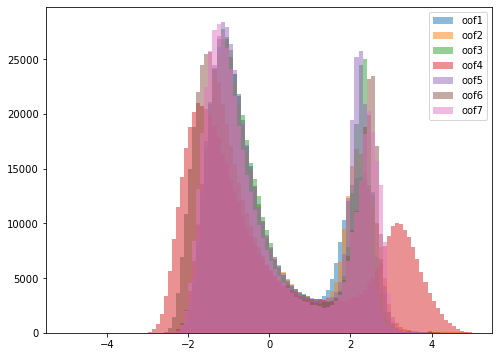

In [8]:
plt.figure(figsize=(8,6))
for o in oof_df.columns[:-3]:
    plt.hist(oof_df[o], bins=100, alpha=0.5, range=[-5, 5], label=o)
plt.legend(loc='upper right');

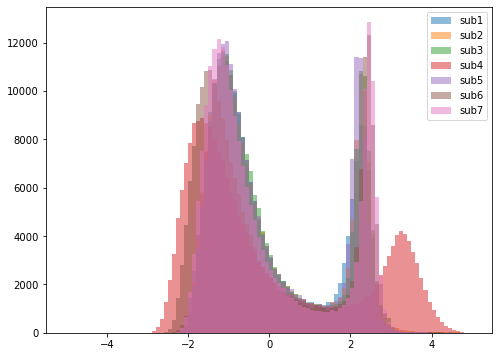

In [9]:
plt.figure(figsize=(8,6))
for s in sub_df.columns[:-1]:
    plt.hist(sub_df[s], bins=100, alpha=0.5, range=[-5, 5], label=s)
plt.legend(loc='upper right');

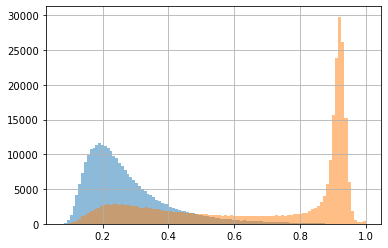

In [10]:
oof_df["mean"] = sigmoid(oof_df[oof_df.columns[:-3]].mean(axis=1))
oof_df[oof_df["target"] == 0]["mean"].hist(bins=100, alpha=0.5);
oof_df[oof_df["target"] == 1]["mean"].hist(bins=100, alpha=0.5);

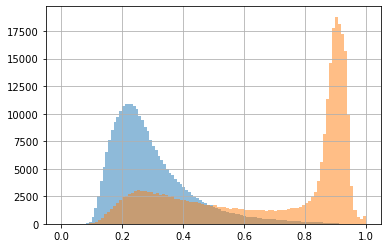

In [11]:
sigmoid(oof_df[oof_df["target"] == 0]["oof2"]).hist(bins=100, alpha=0.5);
sigmoid(oof_df[oof_df["target"] == 1]["oof2"]).hist(bins=100, alpha=0.5);

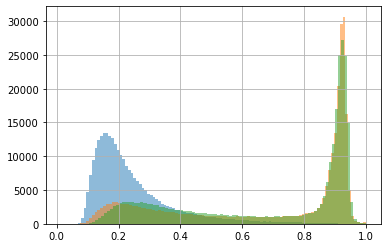

In [12]:
sigmoid(oof_df[oof_df["target"] == 0]["oof6"]).hist(bins=100, alpha=0.5);
sigmoid(oof_df[oof_df["target"] == 1]["oof6"]).hist(bins=100, alpha=0.5);
sigmoid(oof_df[oof_df["target"] == 1]["oof7"]).hist(bins=100, alpha=0.5);

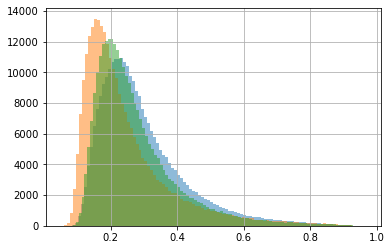

In [13]:
sigmoid(oof_df[oof_df["target"] == 0]["oof2"]).hist(bins=100, alpha=0.5);
sigmoid(oof_df[oof_df["target"] == 0]["oof6"]).hist(bins=100, alpha=0.5);
sigmoid(oof_df[oof_df["target"] == 0]["oof7"]).hist(bins=100, alpha=0.5);

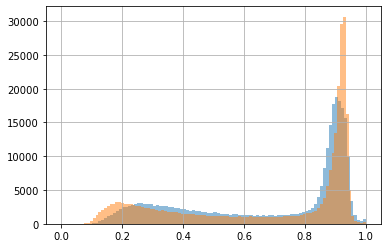

In [14]:
sigmoid(oof_df[oof_df["target"] == 1]["oof2"]).hist(bins=100, alpha=0.5);
sigmoid(oof_df[oof_df["target"] == 1]["oof6"]).hist(bins=100, alpha=0.5);

In [15]:
oof_df[oof_df.columns[:-3]].corr()

,oof1,oof2,oof3,oof4,oof5,oof6,oof7
oof1,1.000000,0.898707,0.982670,0.968708,0.957271,0.958641,0.983501
oof2,0.898707,1.000000,0.891119,0.876754,0.914805,0.874409,0.893965
oof3,0.982670,0.891119,1.000000,0.965701,0.957415,0.959846,0.983137
oof4,0.968708,0.876754,0.965701,1.000000,0.944340,0.944949,0.966353
oof5,0.957271,0.914805,0.957415,0.944340,1.000000,0.971048,0.962318
oof6,0.958641,0.874409,0.959846,0.944949,0.971048,1.000000,0.973033
oof7,0.983501,0.893965,0.983137,0.966353,0.962318,0.973033,1.000000


# Sum, rank & power ensemble

In [16]:
def score_oof(oof, full=False):
    if full:
        return roc_auc_score(oof["target"], oof["prediction"])
    else:
        scores = [roc_auc_score(df["target"], df["prediction"]) for _, df in oof.groupby("fold")]
        return np.mean(scores)

In [17]:
for o in oof_list:
    print(score_oof(o), score_oof(o, True))

0.877331692811547 0.8771328726715698
0.8774939366992385 0.8760220004337729
0.8773306931303623 0.8772440586542842
0.8739256392185666 0.8734175738105372
0.8770651000334055 0.8765776760297274
0.8786987779735206 0.8783552028882716
0.878750927562239 0.8781646062628389


In [18]:
sum_preds = oof1.copy()
sum_preds["prediction"] = 0

for o in oof_list:
    sum_preds["prediction"] += o["prediction"]
    
score_oof(sum_preds)

0.8795515720319222

In [19]:
prob_sum_preds = oof1.copy()
prob_sum_preds["prediction"] = 0

for o in oof_list:
    prob_sum_preds["prediction"] += sigmoid(o["prediction"])
    
score_oof(prob_sum_preds)

0.8795347850729648

In [20]:
rank_preds = oof1.copy()
rank_preds["prediction"] = 0

for o in oof_list:
    rank_preds["prediction"] += o["prediction"].rank()
    
score_oof(rank_preds)

0.879437559971225

In [21]:
for power in [0.25, 0.5, 1.0, 1.5, 2, 4, 8]:
    pow_preds = oof1.copy()
    pow_preds["prediction"] = 0
    for o in oof_list:
        pow_preds["prediction"] += sigmoid(o["prediction"]) ** power

    print(f"{power:0.1f}, {score_oof(pow_preds):0.6f}")

power = 1.5
pow_preds = oof1.copy()
pow_preds["prediction"] = 0
for o in oof_list:
    pow_preds["prediction"] += sigmoid(o["prediction"]) ** power

0.2, 0.879529
0.5, 0.879533
1.0, 0.879535
1.5, 0.879532
2.0, 0.879526
4.0, 0.879476
8.0, 0.879316


In [22]:
# Make a summed submission
sum_sub = sub1.copy()
sum_sub["target"] = 0
for s in sub_list:
    sum_sub["target"] += s["target"]

if SAVE_FILES:
    sum_sub.to_csv(f"stack_subs/summed_ensemble_{score_oof(sum_preds):0.5f}.csv", index=False)

sum_sub.head()

,id,target
0,00005bced6,16.849035
1,0000806717,11.064513
2,0000ef4fe1,-4.880571
3,00020de251,9.812994
4,00024887b5,-10.928978


In [23]:
# Make a ranked submission
rank_sub = sub1.copy()
rank_sub["target"] = 0
for s in sub_list:
    rank_sub["target"] += s["target"].rank()

if SAVE_FILES:
    rank_sub.to_csv(f"stack_subs/ranked_ensemble_{score_oof(rank_preds):0.5f}.csv", index=False)

rank_sub.head()

,id,target
0,00005bced6,1380937.0
1,0000806717,1181002.0
2,0000ef4fe1,778670.0
3,00020de251,1167162.0
4,00024887b5,190787.0


In [24]:
# Make a power submission
pow_sub = sub1.copy()
pow_sub["target"] = 0
for s in sub_list:
    pow_sub["target"] += sigmoid(s["target"]) ** power

if SAVE_FILES:
    pow_sub.to_csv(f"stack_subs/power_ensemble_{score_oof(pow_preds):0.5f}.csv", index=False)

pow_sub.head()

,id,target
0,00005bced6,6.129619
1,0000806717,5.281842
2,0000ef4fe1,1.349487
3,00020de251,5.020445
4,00024887b5,0.521658


# Use `LogisticRegressionCV`

In [25]:
from sklearn.linear_model import LogisticRegressionCV

In [26]:
cols = oof_df.columns[:len(oof_files)]

# opt = LogisticRegressionCV(Cs=50, n_jobs=16, scoring="roc_auc", penalty="elasticnet", solver="saga", l1_ratios=np.linspace(0, 1, 10))
# opt.fit(oof_df[cols], oof_df["target"])
# opt.scores_[1].mean(0).max()

# Use `OptimizeAUC`

In [27]:
# scores = []
# cols = oof_df.columns[:len(oof_files)]

# # poly = PolynomialFeatures(2)

# for fold in range(5):
#     trn_df = oof_df.query(f"fold != {fold}").copy()
#     val_df = oof_df.query(f"fold == {fold}").copy()
    
#     trn_X = sigmoid(trn_df[cols])
#     val_X = sigmoid(val_df[cols])

#     opt = OptimizeAUC("Nelder-Mead")
#     opt.fit(trn_X, trn_df["target"])
#     y_pred = opt.predict(val_df[cols])
# #     y_pred = opt.predict_proba(val_X)[:, 1]
#     scores.append(roc_auc_score(val_df["target"], y_pred))
#     print(f"Fold {fold}, validation score: {scores[-1]:0.6f}") # , opt.res_.x)
#     print()
    
# print()
# print(f"Mean score: {np.mean(scores):0.6f}")

# # Fit on full OOFs and predict on test
# opt = OptimizeAUC()
# opt.fit(oof_df[cols], oof_df["target"])
# print()
# print("Weights", opt.coef_)
# test_preds = opt.predict(sub_df.iloc[:, :-1])


# Mean score: 0.879274
# Mean score: 0.879286

# Create Pseudo-labels

In [28]:
test_paths = [OUTPUT_PATH / f.split("_")[1] / f.replace("oofs", "test") for f in oof_files]

test_list = [pd.read_csv(p) for p in test_paths]

test1 = test_list[0]
pl_df = pd.DataFrame(test_list[0][["id"]])

for i in range(5):
    fold_labels = 0
    for t in test_list:
        fold_labels += t[f"fold_{i}"]
        
    pl_df[f"fold_{i}"] = sigmoid(fold_labels / len(test_list))
    

pl_df["mean"] = pl_df[pl_df.columns[1:]].mean(axis=1)

if SAVE_FILES:
    pl_df.to_csv(INPUT_PATH / "pl_5_model_ensemble.csv", index=False)
        
pl_df.head()

,id,fold_0,fold_1,fold_2,fold_3,fold_4,mean
0,00005bced6,0.917028,0.915698,0.923584,0.906600,0.922888,0.917159
1,0000806717,0.828213,0.834357,0.840458,0.834877,0.807080,0.828997
2,0000ef4fe1,0.326089,0.315983,0.356387,0.326407,0.337975,0.332568
3,00020de251,0.808227,0.791323,0.799086,0.814901,0.798198,0.802347
4,00024887b5,0.172984,0.168963,0.170359,0.181313,0.173900,0.173504


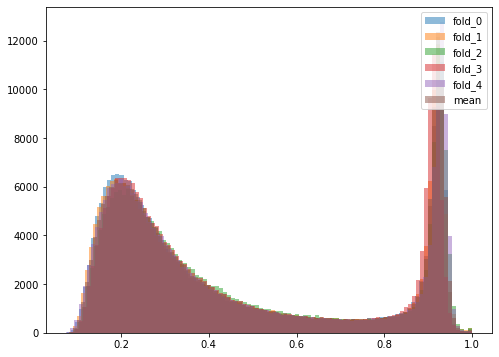

In [29]:
pl_df_filtered = pl_df # .query("(mean < 0.4) | (mean > 0.8 & mean < 0.99)")

plt.figure(figsize=(8,6))
for c in pl_df.columns[1:]:
    plt.hist(pl_df_filtered[c], bins=100, alpha=0.5, label=c)
plt.legend(loc='upper right');

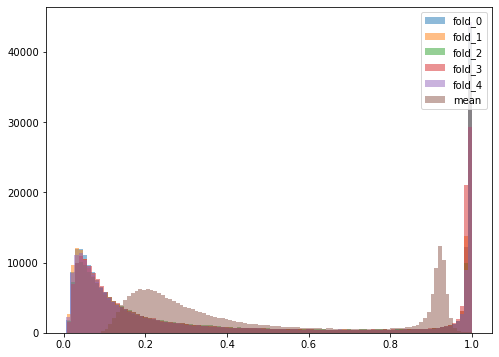

In [40]:
# Harden PLs
cols = [f"fold_{i}" for i in range(5)]
pl_df_hard = pl_df.copy()
idxs = pl_df_hard["mean"] > 0
pl_df_hard.loc[idxs, cols] = sigmoid(logit(pl_df_hard.loc[idxs, cols]) * 2)


plt.figure(figsize=(8,6))
for c in pl_df.columns[1:]:
    plt.hist(pl_df_hard[c], bins=100, alpha=0.5, label=c)
plt.legend(loc='upper right');

0.006448414634840949 1.0


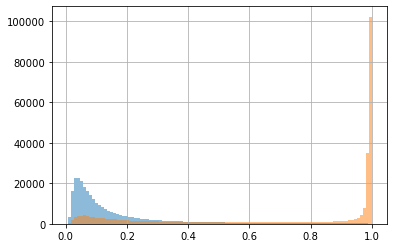

In [37]:
oof_df["mean_hard"] = sigmoid(logit(oof_df["mean"]) * 2)

print(oof_df["mean_hard"].min(), oof_df["mean_hard"].max())

oof_df[oof_df["target"] == 0]["mean_hard"].hist(bins=100, alpha=0.5);
oof_df[oof_df["target"] == 1]["mean_hard"].hist(bins=100, alpha=0.5);

In [41]:
oof_df[(oof_df["target"] == 1) & (oof_df["mean"] < 0.5)].shape[0] / oof_df[oof_df["target"] == 1].shape[0]

0.3045154145679277

# Linear weighting

In [32]:
# def calc_weights(df1, df2):
    
#     def func(weight):
#         return score_oof(weight_dfs(df1, df2, weight))

#     weights = []
#     sweep = np.linspace(0, 1, 101)

#     scores = np.array([func(w) for w in sweep])
#     weights.append(sweep[np.argmax(scores)])
        
#     return weights


# def weight_dfs(df1, df2, w):
#     df_out = df1.copy()
#     df_out["prediction"] = w * df1["prediction"] + (1 - w) * df2["prediction"]
#     return df_out


# def stack(df1, df2):
#     weights = calc_weights(df1, df2)
#     print(list(np.round(weights, 2)))
    
#     sub = weight_dfs(df1, df2, weights)
#     print(score_df(sub, gt))
#     return sub

In [33]:
# calc_weights(oof1, oof3)